In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from google.cloud import bigquery
from matplotlib import pyplot as plt

import seaborn as sns

from dotenv import load_dotenv
load_dotenv("/Users/juanluis/Documents/credentials/env.txt")

True

In [2]:
bq_client = bigquery.Client()

In [3]:
function = "median"
stocks = ['AAPL', 'GS', 'KHC', 'MCD', 'MSFT', 'OXY', 'PEP']
#stocks = ["AAPL"]

In [4]:
series = { k : f'stock-sentiment-nlp.series.{k}_titles_{function}' for k in stocks}

In [5]:
datasets = {}
for ticker, table in series.items():
    sentiment = bq_client.query(f"SELECT * FROM `{table}`").result().to_dataframe().set_index("index").sort_index()
    sentiment.index = list(map(lambda ts : ts.tz_convert(None), sentiment.index))
    
    start_date = sentiment.index.min()
    end_date = sentiment.index.max()
    market = yf.download(ticker, start_date, end_date)
    data = pd.merge(market, sentiment, right_index = True, left_index = True, how = "right" )
    datasets[ticker] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
aapl

,Open,High,Low,Close,Adj Close,Volume,star1,star2,star3,star4,star5
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.144579,0.122812,0.194046,0.247848,0.258910
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.382229,148158800.0,0.382793,0.254007,0.149624,0.091431,0.041303
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.559071,365248800.0,0.481067,0.251710,0.132312,0.065447,0.048287
2019-01-04,36.132500,37.137501,35.950001,37.064999,36.034378,234428400.0,0.261322,0.155554,0.137853,0.086791,0.061887
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.340321,0.188549,0.140744,0.123932,0.117098
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,0.198529,0.213221,0.211733,0.156335,0.109795
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050766,124486200.0,0.260756,0.323520,0.077126,0.037465,0.012137
2020-12-29,138.050003,138.789993,134.339996,134.869995,134.239273,121047300.0,0.419241,0.150327,0.080800,0.116714,0.163099
2020-12-30,135.580002,135.990005,133.399994,133.720001,133.094650,96452100.0,0.138923,0.088534,0.173090,0.248339,0.349870


In [56]:
aapl = datasets["AAPL"]

In [46]:
df = aapl.filter(regex = "star|^Close|^Volume")
df = df[~df.Close.isna()]

In [20]:
df.Close.diff()

2019-01-01         NaN
2019-01-02         NaN
2019-01-03   -1.019997
2019-01-04    2.220001
2019-01-05         NaN
                ...   
2020-12-27         NaN
2020-12-28         NaN
2020-12-29    0.509995
2020-12-30   -0.110001
2020-12-31         NaN
Name: Close, Length: 731, dtype: float64

In [59]:
variable = "return"
corr = {}
for s in stocks:
    df = datasets[s].bfill()
    df = df.filter(regex = "star|^Close|^Volume")
    df["log_return"] = np.log(1 + df.Close.pct_change())
    df["return"] = df.Close.pct_change()
    df["diff_return"] = df.Close.diff()
    df["diff_log_return"] = df.log_return.diff()
    df["growth"] = df["return"] >= 0
    df_corr = df.corr()
    corr[s] = df_corr[variable]


<AxesSubplot:>

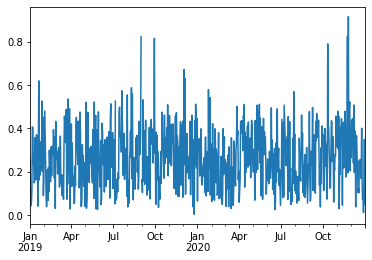

In [71]:
aapl.star5.plot()

<AxesSubplot:>

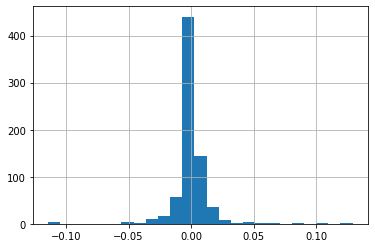

In [69]:
df["return"].hist(bins = 25)

In [61]:
print(variable)
corr_df = pd.DataFrame(corr).drop(variable).filter(like = "star", axis = 0)
corr_df.style.background_gradient(axis = None, cmap = "RdBu", subset = None)

return


,AAPL,GS,KHC,MCD,MSFT,OXY,PEP
star1,-0.075414,0.010308,-0.022544,0.002605,0.034602,0.042304,-0.034547
star2,-0.055703,-0.027032,-0.034555,0.028842,0.029335,0.016545,-0.002372
star3,0.027912,-0.020329,0.010307,0.019215,0.007456,-0.029909,-0.037958
star4,0.028875,0.005643,0.038176,-0.002340,-0.024560,-0.026793,-0.003693
star5,0.072943,0.027277,0.026833,-0.029681,-0.035134,-0.026513,0.022425


In [47]:
print(variable)
corr_df = pd.DataFrame(corr).drop(variable).filter(like = "star", axis = 0)
corr_df.style.background_gradient(axis = None, cmap = "RdBu", subset = None)

return


,AAPL,GS,KHC,MCD,MSFT,OXY,PEP
star1,-0.075414,0.010308,-0.022544,0.002605,0.034602,0.042304,-0.034547
star2,-0.055703,-0.027032,-0.034555,0.028842,0.029335,0.016545,-0.002372
star3,0.027912,-0.020329,0.010307,0.019215,0.007456,-0.029909,-0.037958
star4,0.028875,0.005643,0.038176,-0.002340,-0.024560,-0.026793,-0.003693
star5,0.072943,0.027277,0.026833,-0.029681,-0.035134,-0.026513,0.022425


In [7]:
pd.DataFrame(corr).drop("return").style.background_gradient(axis = 1)

,AAPL,GS,KHC,MCD,MSFT,OXY,PEP
Close,0.048357,0.112592,0.056488,0.082475,0.032001,0.002053,0.095048
Volume,-0.075875,0.044003,-0.405586,-0.082471,-0.058176,0.097111,-0.013064
star1,-0.079502,0.010613,-0.038847,-0.001344,0.012290,0.009391,-0.014554
star2,-0.079272,0.027519,-0.055953,0.005669,0.027736,-0.010853,0.021039
star3,-0.041347,0.050538,0.026407,0.022469,0.025601,0.019218,-0.004676
star4,0.049096,-0.023884,0.054095,-0.013598,0.002277,0.002983,0.006781
star5,0.078138,-0.005603,0.041216,-0.023875,-0.035589,-0.005790,-0.013860
log_return,0.999422,0.999042,0.996741,0.998606,0.999275,0.983794,0.999172


In [74]:
df["log_return"] = np.log(1 + df.Close.pct_change())

/var/folders/cx/865gkv912xj3_mfvrtptff_r0000gp/T/ipykernel_17208/816428999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_return"] = np.log(1 + df.Close.pct_change())


<AxesSubplot:>

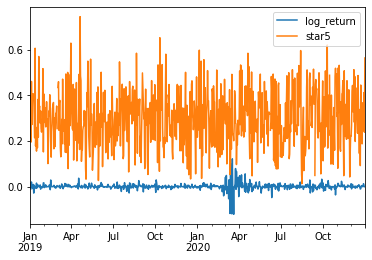

In [75]:
df[["log_return", "star5"]].plot()

In [48]:
df.corr().style.background_gradient(axis = 1)

,Close,Volume,star1,star2,star3,star4,star5
Close,1.000000,0.139226,-0.068409,-0.072101,-0.075997,0.042439,0.093925
Volume,0.139226,1.000000,0.129859,0.111591,0.016120,-0.112721,-0.114764
star1,-0.068409,0.129859,1.000000,0.730971,0.068332,-0.843090,-0.828133
star2,-0.072101,0.111591,0.730971,1.000000,0.541292,-0.738128,-0.875984
star3,-0.075997,0.016120,0.068332,0.541292,1.000000,-0.002678,-0.572327
star4,0.042439,-0.112721,-0.843090,-0.738128,-0.002678,1.000000,0.587963
star5,0.093925,-0.114764,-0.828133,-0.875984,-0.572327,0.587963,1.000000


In [39]:
#mean
df.corr().style.background_gradient(axis = 1)

,Close,star1,star2,star3,star4,star5,log_return
Close,1.000000,-0.068409,-0.072101,-0.075997,0.042439,0.093925,0.047138
star1,-0.068409,1.000000,0.730971,0.068332,-0.843090,-0.828133,-0.089325
star2,-0.072101,0.730971,1.000000,0.541292,-0.738128,-0.875984,-0.099448
star3,-0.075997,0.068332,0.541292,1.000000,-0.002678,-0.572327,-0.061055
star4,0.042439,-0.843090,-0.738128,-0.002678,1.000000,0.587963,0.072301
star5,0.093925,-0.828133,-0.875984,-0.572327,0.587963,1.000000,0.105258
log_return,0.047138,-0.089325,-0.099448,-0.061055,0.072301,0.105258,1.000000


In [27]:
#median
df.corr().style.background_gradient(axis = 1)

,Close,star1,star2,star3,star4,star5,log_return
Close,1.000000,-0.108432,-0.055746,-0.077171,0.075194,0.084968,0.047138
star1,-0.108432,1.000000,0.780646,0.185798,-0.829076,-0.805552,-0.101093
star2,-0.055746,0.780646,1.000000,0.445008,-0.720977,-0.916030,-0.098539
star3,-0.077171,0.185798,0.445008,1.000000,-0.018923,-0.479403,-0.048148
star4,0.075194,-0.829076,-0.720977,-0.018923,1.000000,0.664032,0.063430
star5,0.084968,-0.805552,-0.916030,-0.479403,0.664032,1.000000,0.100253
log_return,0.047138,-0.101093,-0.098539,-0.048148,0.063430,0.100253,1.000000


In [15]:
#max
df.corr().style.background_gradient(axis = 1)

,Close,star1,star2,star3,star4,star5,log_return
Close,1.000000,-0.010120,-0.054148,-0.037679,0.013873,0.089290,0.047138
star1,-0.010120,1.000000,0.155360,-0.030283,-0.112245,-0.152144,-0.076915
star2,-0.054148,0.155360,1.000000,0.255793,-0.096215,-0.068296,-0.036642
star3,-0.037679,-0.030283,0.255793,1.000000,0.002724,-0.081297,-0.076283
star4,0.013873,-0.112245,-0.096215,0.002724,1.000000,0.022353,0.010181
star5,0.089290,-0.152144,-0.068296,-0.081297,0.022353,1.000000,0.036070
log_return,0.047138,-0.076915,-0.036642,-0.076283,0.010181,0.036070,1.000000


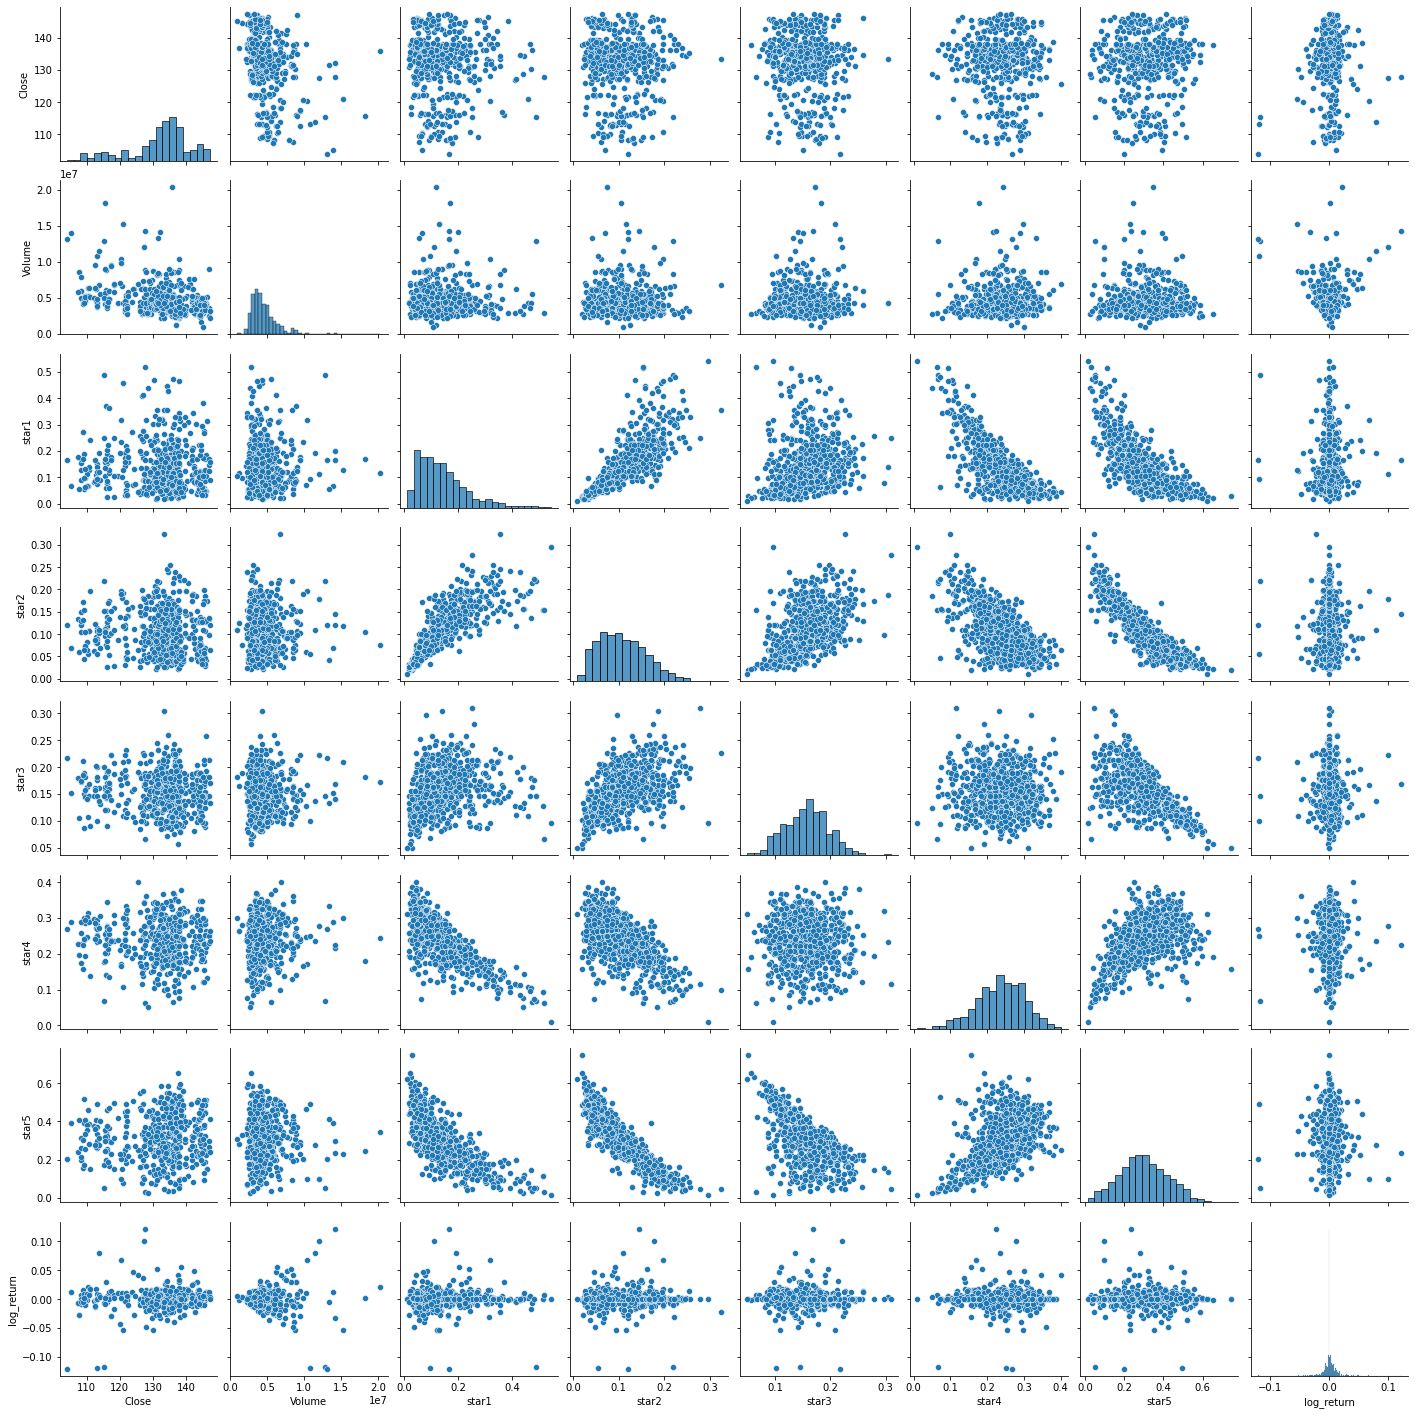

In [76]:
sns.pairplot(df)

In [155]:
from fbprophet import Prophet
m = Prophet()

In [108]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [146]:
def diff(x):
    sign = 1 if x.Open <= x.Close else -1
    return sign * (x.High - x.Low)

In [153]:
aapl.filter(regex = "star|diff").corr().style.background_gradient(axis = 1)

,star1,star2,star3,star4,star5,diff
star1,1.000000,0.607320,-0.214453,-0.833963,-0.732114,-0.007784
star2,0.607320,1.000000,0.379535,-0.706375,-0.823779,0.037658
star3,-0.214453,0.379535,1.000000,0.178285,-0.450663,0.049647
star4,-0.833963,-0.706375,0.178285,1.000000,0.525927,-0.024774
star5,-0.732114,-0.823779,-0.450663,0.525927,1.000000,-0.012754
diff,-0.007784,0.037658,0.049647,-0.024774,-0.012754,1.000000


In [265]:
aapl["diff"] = aapl.apply(diff, axis = 1)

cols = ["Close", "Volume", "star1", "star2", "star3", "star4", "star5"]
df = aapl[cols]

df = pd.merge(df[["Close"]], df.filter(like = "star").shift(1), right_index=True, left_index=True)

import datetime

df = df.bfill()
df["returns"] = df.Close.pct_change()
threshold = datetime.date.fromisoformat("2019-12-31")
train = df.loc[:threshold]
test = df.loc[threshold + datetime.timedelta(days = 1) :]

In [346]:
df = pd.merge(df[["log_return"]], df.filter(like = "star").shift(1), right_index=True, left_index=True)

df = df.bfill()
threshold = datetime.date.fromisoformat("2019-12-31")
train = df.loc[:threshold]
test = df.loc[threshold + datetime.timedelta(days = 1) :]

In [347]:
def rename_cols(df):
    return df.reset_index().rename(columns = {"index" : "ds", "log_return" : "y"}).copy()

In [348]:
train = rename_cols(train)
test  = rename_cols(test)

In [350]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('star1')
m.add_regressor('star2')
m.add_regressor('star3')
m.add_regressor('star4')
m.add_regressor('star5')


In [351]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -46.3262


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       322.993    0.00084448        98.555      0.7167      0.7167      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       323.053   2.32482e-09       90.9763      0.2133      0.2133      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [352]:
forecast = m.predict(test)

In [357]:
np.corrcoef(forecast.y, forecast.yhat)

array([[1.       , 0.0245527],
       [0.0245527, 1.       ]])

In [353]:
forecast["y"] = test.y

<AxesSubplot:>

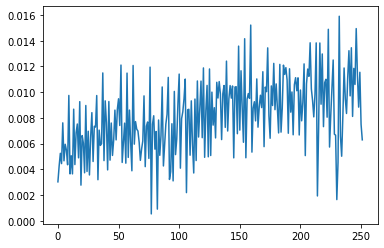

In [359]:
forecast.yhat.plot()


<AxesSubplot:>

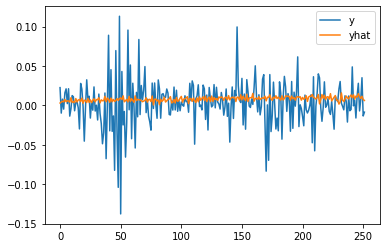

In [354]:
forecast[["y", "yhat"]].plot()

In [122]:
df[["Close", "Volume"]].shift(-1)

,Close,Volume
2019-01-01,39.480000,148158800.0
2019-01-02,35.547501,365248800.0
2019-01-03,37.064999,234428400.0
2019-01-04,NaN,NaN
2019-01-05,NaN,NaN
...,...,...
2020-12-27,136.690002,124486200.0
2020-12-28,134.869995,121047300.0
2020-12-29,133.720001,96452100.0
2020-12-30,NaN,NaN


In [110]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


macrodata = sm.datasets.macrodata.load_pandas().data
data = macrodata.iloc[:, 2:4]
data.tail(2)

,realgdp,realcons
201,12901.504,9189.0
202,12990.341,9256.0


In [114]:


path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
# summarize shape
print(df.shape)
# show first few rows
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


In [100]:
import pickle
with open("/Users/juanluis/Documents/ML_Project_Stock_price_Prediction/train_news_data", 'rb') as f:
    file = pickle.load(f)

In [292]:
aapl.pct_change()

,Open,High,Low,Close,Adj Close,Volume,star1,star2,star3,star4,star5,diff
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.721250,1.343212,0.310181,-0.548903,-0.688352,NaN
2019-01-03,-0.070437,-0.082657,-0.079297,-0.099607,-0.099607,1.465252,0.293338,-0.126817,-0.472213,-0.132490,0.246596,-1.805193
2019-01-04,0.003820,0.019421,0.012676,0.042689,0.042689,-0.358168,-0.256083,0.297897,1.082555,0.041295,-0.430648,-2.276881
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003403,-0.374094,-0.259831,0.787425,1.288477,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.361117,0.047673,0.080526,-0.033408,1.756556,0.000000
2020-12-28,0.020332,0.029072,0.018383,0.035766,0.035766,1.266266,0.078682,0.049775,-0.315992,-0.672891,0.496384,0.622882
2020-12-29,0.030301,0.010558,0.006217,-0.013315,-0.013315,-0.027625,0.732378,-0.259377,-0.130248,1.981812,-0.669449,-2.161879
2020-12-30,-0.017892,-0.020174,-0.006997,-0.008527,-0.008527,-0.203187,-0.134181,-0.025199,0.183839,-0.045576,0.562985,-0.417975


In [83]:

from fbprophet import Prophet

train_size = 252*3                     # Use 3 years of data as train set
val_size = 252                         # Use 1 year of data as validation set
train_val_size = train_size + val_size # Size of train+validation set
i = train_val_size                     # Day to forecast
H = 21                                 # Forecast horizon

# Fit prophet model
m = Prophet()
m.fit(aapl[i-train_val_size:i])

# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [77]:
aapl.corr().style.background_gradient(axis = 1)

,Open,High,Low,Close,Adj Close,Volume,star1,star2,star3,star4,star5
Open,1.000000,0.999453,0.999219,0.998688,0.998686,0.141304,0.025528,-0.018373,-0.022609,-0.032558,0.010475
High,0.999453,1.000000,0.999030,0.999301,0.999315,0.155985,0.027009,-0.016376,-0.021486,-0.034156,0.008525
Low,0.999219,0.999030,1.000000,0.999342,0.999329,0.124475,0.022838,-0.018936,-0.020876,-0.031129,0.012071
Close,0.998688,0.999301,0.999342,1.000000,0.999990,0.139226,0.023738,-0.017578,-0.020513,-0.032387,0.011109
Adj Close,0.998686,0.999315,0.999329,0.999990,1.000000,0.139923,0.023526,-0.017877,-0.020505,-0.032147,0.011326
Volume,0.141304,0.155985,0.124475,0.139226,0.139923,1.000000,0.170144,0.110799,-0.018215,-0.133694,-0.143802
star1,0.025528,0.027009,0.022838,0.023738,0.023526,0.170144,1.000000,0.607320,-0.214453,-0.833963,-0.732114
star2,-0.018373,-0.016376,-0.018936,-0.017578,-0.017877,0.110799,0.607320,1.000000,0.379535,-0.706375,-0.823779
star3,-0.022609,-0.021486,-0.020876,-0.020513,-0.020505,-0.018215,-0.214453,0.379535,1.000000,0.178285,-0.450663
star4,-0.032558,-0.034156,-0.031129,-0.032387,-0.032147,-0.133694,-0.833963,-0.706375,0.178285,1.000000,0.525927


In [57]:
sentiment.index

,star1,star2,star3,star4,star5
2019-07-07,NaN,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN
2019-12-14,0.143808,0.130184,0.179283,0.229996,0.316729
...,...,...,...,...,...
2020-10-30,0.330561,0.156033,0.140753,0.161783,0.210869
2020-10-07,0.330035,0.173346,0.122401,0.162511,0.211708
2020-04-14,0.095117,0.110280,0.204695,0.305242,0.284666
2020-10-16,0.237886,0.183015,0.185355,0.201870,0.191874


In [79]:
import matplotlib.pylab as plt

[]

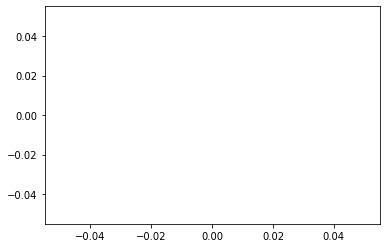

In [80]:
plt.plot()

In [54]:
market.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None)

In [45]:
end_date

Timestamp('2020-12-31 00:00:00')

In [44]:
start_date

Timestamp('2019-01-01 00:00:00')

In [35]:
t = sentiment.index[0]


In [40]:
sentiment.index.apply(True)

AttributeError: 'DatetimeIndex' object has no attribute 'apply'

In [18]:
s = aapl.set_index("index").corr().style

In [20]:
s.

,star1,star2,star3,star4,star5
star1,1.000000,0.607320,-0.214453,-0.833963,-0.732114
star2,0.607320,1.000000,0.379535,-0.706375,-0.823779
star3,-0.214453,0.379535,1.000000,0.178285,-0.450663
star4,-0.833963,-0.706375,0.178285,1.000000,0.525927
star5,-0.732114,-0.823779,-0.450663,0.525927,1.000000


<AxesSubplot:>

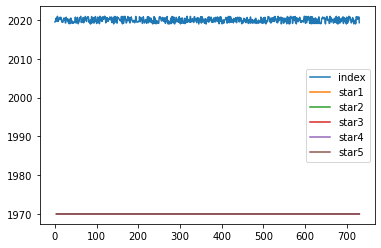

In [9]:
aapl.plot()